In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#### Load Dataset and Perform EDA

In [63]:
dataset = pd.read_csv('datasets/cleaned/fx_predictions_dataset.csv')
dataset.head()

,Date,Buying,Selling,Mid Rate,GDP,Interbank weighted average rate,Monetary policy rate,Oil_Price,Cocoa_Price,Gold_Price,Headline Inflation
0,30/11/2023,11.61,11.6264,11.6206,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
1,29/11/2023,11.61,11.6169,11.6111,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
2,28/11/2023,11.59,11.6049,11.5991,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
3,27/11/2023,11.58,11.5958,11.59,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
4,24/11/2023,11.58,11.5888,11.583,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41


In [64]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date                             3950 non-null   object 
 1   Buying                           3950 non-null   float64
 2   Selling                          3950 non-null   object 
 3   Mid Rate                         3950 non-null   object 
 4   GDP                              3950 non-null   float64
 5   Interbank weighted average rate  3950 non-null   float64
 6   Monetary policy rate             3950 non-null   float64
 7   Oil_Price                        3950 non-null   float64
 8   Cocoa_Price                      3950 non-null   float64
 9   Gold_Price                       3950 non-null   float64
 10  Headline Inflation               3950 non-null   float64
dtypes: float64(8), object(3)
memory usage: 339.6+ KB


In [65]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             3950 non-null   datetime64[ns]
 1   Buying                           3950 non-null   float64       
 2   Selling                          3950 non-null   object        
 3   Mid Rate                         3950 non-null   object        
 4   GDP                              3950 non-null   float64       
 5   Interbank weighted average rate  3950 non-null   float64       
 6   Monetary policy rate             3950 non-null   float64       
 7   Oil_Price                        3950 non-null   float64       
 8   Cocoa_Price                      3950 non-null   float64       
 9   Gold_Price                       3950 non-null   float64       
 10  Headline Inflation               3950 non-null   float64    

/var/folders/pq/lv4328kx4fjg40sltdfjtrcm0000gn/T/ipykernel_85180/3134352350.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset['Date'] = pd.to_datetime(dataset['Date'])


In [66]:
dataset.drop(columns=['Selling', 'Mid Rate'], inplace=True)

In [67]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             3950 non-null   datetime64[ns]
 1   Buying                           3950 non-null   float64       
 2   GDP                              3950 non-null   float64       
 3   Interbank weighted average rate  3950 non-null   float64       
 4   Monetary policy rate             3950 non-null   float64       
 5   Oil_Price                        3950 non-null   float64       
 6   Cocoa_Price                      3950 non-null   float64       
 7   Gold_Price                       3950 non-null   float64       
 8   Headline Inflation               3950 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 277.9 KB


In [68]:
dataset.rename(columns={'Interbank weighted average rate': 'InterBankAvgInterestRate', 'Monetary policy rate': 'MPR', 'Oil_Price': 'OilPrice',
          'Cocoa_Price': 'CocoaPrice', 'Food Inflation': 'FoodInflation', 'Headline Inflation': 'HeadlineInflation'}, inplace=True)

In [69]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      3950 non-null   datetime64[ns]
 1   Buying                    3950 non-null   float64       
 2   GDP                       3950 non-null   float64       
 3   InterBankAvgInterestRate  3950 non-null   float64       
 4   MPR                       3950 non-null   float64       
 5   OilPrice                  3950 non-null   float64       
 6   CocoaPrice                3950 non-null   float64       
 7   Gold_Price                3950 non-null   float64       
 8   HeadlineInflation         3950 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 277.9 KB


In [70]:
dataset = dataset.set_index('Date').sort_index()

In [71]:
dataset.head()

,Buying,GDP,InterBankAvgInterestRate,MPR,OilPrice,CocoaPrice,Gold_Price,HeadlineInflation
Date,,,,,,,,
2008-01-02,0.95,18863.43405,12.2,13.5,91.92,2174.55,890.98,12.81
2008-01-03,0.95,18863.43405,12.2,13.5,91.92,2174.55,890.98,12.81
2008-01-04,0.95,18863.43405,12.2,13.5,91.92,2174.55,890.98,12.81
2008-01-07,0.96,18863.43405,12.2,13.5,91.92,2174.55,890.98,12.81
2008-01-08,0.96,18863.43405,12.2,13.5,91.92,2174.55,890.98,12.81


In [72]:
# dataset_80 = dataset.iloc[:int(len(dataset) * 0.8)]

In [73]:
split_index = int(len(dataset) * 0.8)
split_index

3160

In [74]:
# 120 to accommodate the quarterly data. Since the data for gdp was spread into daily
# the same values will be seen across 3 months, we use 120 to prevent this so the model
# can see different values
window_size = 120
#120 *, 60, 90

In [75]:
target_column = 'Buying'

In [76]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

In [77]:
def create_sequences(features):
    """Converts 2D daily data into 3D sequences (Samples, Timesteps, Features)."""
    x, y = [], []
    for i in range(len(features) - window_size):
        # X: The sequence of 'lookback' days leading up to the target day
        x.append(features[i:i + window_size])
        # y: The target value (Mid Rate) for the day immediately following the sequence
        y.append(features[i + window_size])
    return np.array(x), np.array(y)

In [78]:
x_train, y_train = create_sequences(scaled)
x_test, y_test = create_sequences(scaled)

In [79]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3830, 120, 8), (3830, 8), (3830, 120, 8), (3830, 8))

In [80]:
 # The `epoch` is one complete iteration through the entire training dataset.
 # During each epoch, the model learns from the entire dataset and updates its weights. to minimize the loss function.
 # The `batch size` is the number of samples that will be propagated through the network at once.
 # The `learning rate` controls how much to change the model in response to the estimated error each time the model weights are updated.
def train_neural_network(x_train, y_train, epochs=5, learning_rate=0.005):
    model = Sequential()
    model.add(InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])))
    # model.add(InputLayer(input_shape=(window_size, 1)))
    model.add(LSTM(50, return_sequences=True))
    # model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=MeanSquaredError(),
                  metrics=[RootMeanSquaredError()])

    checkpoint = ModelCheckpoint('models/best_lstm_model.h5', monitor='loss',
                                 save_best_only=True, mode='min', verbose=1)

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=[checkpoint], verbose=1)

    # history = model.fit(x_train, y_train, epochs=epochs, batch_size=32,
    #                     validation_data=(x_val, y_val), callbacks=[checkpoint], verbose=1)
    return model, history

In [81]:
model, history = train_neural_network(x_train, y_train, epochs=20, learning_rate=0.001)

Epoch 1/20


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0693 - root_mean_squared_error: 0.2605
Epoch 1: loss improved from None to 0.05640, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0564 - root_mean_squared_error: 0.2375
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0525 - root_mean_squared_error: 0.2291
Epoch 2: loss improved from 0.05640 to 0.05192, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0519 - root_mean_squared_error: 0.2279
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287
Epoch 3: loss improved from 0.05192 to 0.05189, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0522 - root_mean_squared_error: 0.2285
Epoch 4: loss improved from 0.05189 to 0.05187, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0515 - root_mean_squared_error: 0.2270
Epoch 5: loss improved from 0.05187 to 0.05186, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0519 - root_mean_squared_error: 0.2277
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0520 - root_mean_squared_error: 0.2281
Epoch 6: loss improved from 0.05186 to 0.05186, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0519 - root_mean_squared_error: 0.2277
Epoch 7/20
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0515 - root_mean_squared_error: 0.2269
Epoch 7: loss improved from 0.05186 to 0.05185, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0519 - root_mean_squared_error: 0.2277
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0517 - root_mean_squared_error: 0.2273
Epoch 8: loss improved from 0.05185 to 0.05185, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 9/20
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0514 - root_mean_squared_error: 0.2268
Epoch 9: loss improved from 0.05185 to 0.05185, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 10/20
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260
Epoch 10: loss did not improve from 0.05185
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0521 - root_mean_squared_error: 0.2284
Epoch 11: loss did not improve from 0.05185
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0515 - root_mean_squared_error: 0.2270
Epoch 12: loss improved from 0.05185 to 0.05184, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0518 - root_mean_squared_error: 0.2276
Epoch 13: loss improved from 0.05184 to 0.05184, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0518 - root_mean_squared_error: 0.2275
Epoch 14: loss improved from 0.05184 to 0.05184, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278
Epoch 15: loss improved from 0.05184 to 0.05184, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 16/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0519 - root_mean_squared_error: 0.2279
Epoch 16: loss did not improve from 0.05184
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 17/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278
Epoch 17: loss improved from 0.05184 to 0.05183, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 18/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0522 - root_mean_squared_error: 0.2285
Epoch 18: loss did not improve from 0.05183
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 19/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0517 - root_mean_squared_error: 0.2273
Epoch 19: loss improved from 0.05183 to 0.05182, saving model to models/best_lstm_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
Epoch 20/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0515 - root_mean_squared_error: 0.2270
Epoch 20: loss did not improve from 0.05182
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277


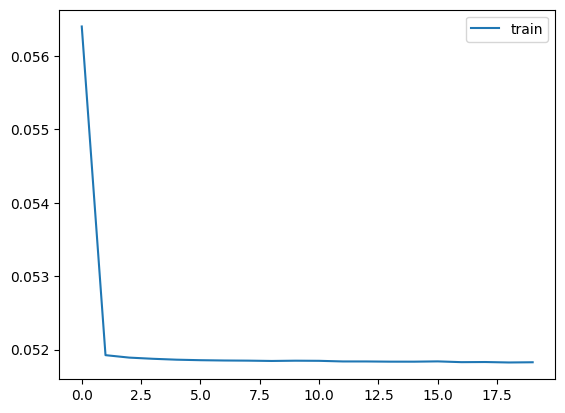

In [82]:
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [83]:
model = load_model('models/best_lstm_model.h5')

In [84]:
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_train)

120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [85]:
# Inverse transform the predictions and true values to get back to the actual scale

# If you used a scaler for y, e.g., MinMaxScaler, and you have it as `y_scaler`
# The y_train and train_predictions may need to be reshaped for inverse_transform

# Assuming y_scaler is available, and that predictions/targets are 2D
# Only inverse transform the first column if scaler was fit on all features
train_predictions_actual = scaler.inverse_transform(
    np.concatenate([
        train_predictions,
        np.zeros((train_predictions.shape[0], scaler.n_features_in_ - train_predictions.shape[1]))
    ], axis=1)
)[:, 0].reshape(-1, 1)
# Pad y_train with zeros to match the number of features used in scaler, then inverse transform and select target column
# Ensure y_train is at least 2D for correct concatenation along axis=1
if y_train.ndim == 1:
    y_train_2d = y_train.reshape(-1, 1)
else:
    y_train_2d = y_train

y_train_padded = np.concatenate([
    y_train_2d,
    np.zeros((y_train_2d.shape[0], scaler.n_features_in_ - 1))
], axis=1)
# Fix: Use the correct scaler for y, not the whole input scaler if available.
# If you only scaled the target variable y, use that scaler (e.g. y_scaler) here.
# Otherwise, for single-output with full-feature fit, pad to scaler.n_features_in_
if hasattr(scaler, 'n_features_in_') and y_train_padded.shape[1] != scaler.n_features_in_:
    n_missing = scaler.n_features_in_ - y_train_padded.shape[1]
    if n_missing > 0:
        y_train_padded = np.concatenate([
            y_train_padded,
            np.zeros((y_train_padded.shape[0], n_missing))
        ], axis=1)
    elif n_missing < 0:
        y_train_padded = y_train_padded[:, :scaler.n_features_in_]

y_train_actual = scaler.inverse_transform(y_train_padded)[:, 0].reshape(-1, 1)

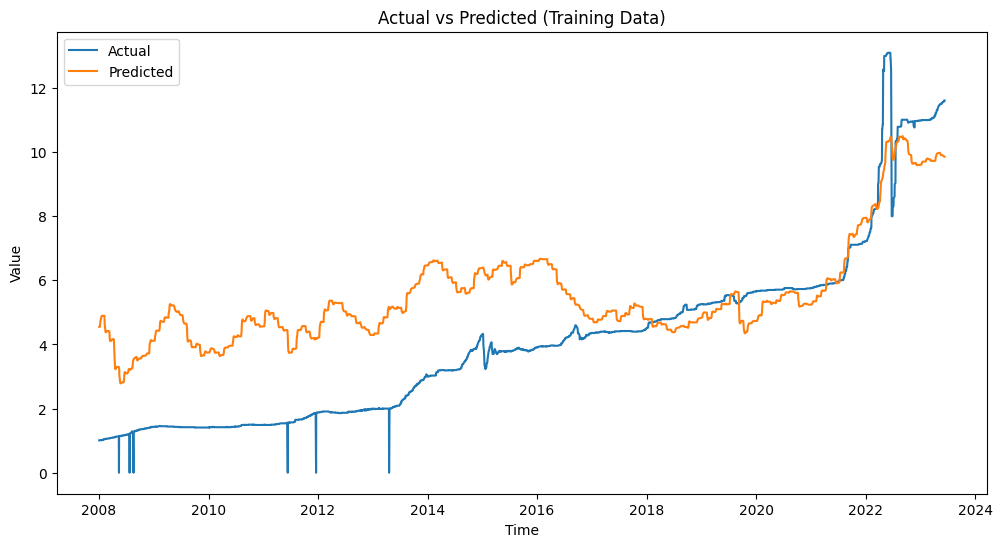

In [86]:


# Create an x-axis of dates for the training period, if available
# If your y_train came from a dataframe with Date index or column use it
# Otherwise, just use np.arange or dataset index matching the training rows

# Example: If you used a DataFrame and have its index as dates:
# train_dates = dataset.index[:len(y_train_actual)]
# If unavailable, default to row indices
# Use actual date values from the training set if available
# Assuming you have a DataFrame or Series with aligned dates for the y_train data
# For example, if your training set comes from splitting a DataFrame with a Date index:
if 'train_idx' in locals():
    # Use train indices in original order (oldest to latest), we'll reverse later for plotting
    train_dates = dataset.index[train_idx]
elif hasattr(dataset, 'index') and len(dataset.index) >= len(y_train_actual):
    train_dates = dataset.index[:len(y_train_actual)]
elif 'train_dates' in globals():
    train_dates = train_dates
else:
    raise ValueError("No date information found for training set.")

# Reverse both dates and actuals/predictions so that the latest date appears first on the plot,
# and corresponding y values are matched in time
train_dates = train_dates[::-1]
y_train_actual = y_train_actual[::-1]
train_predictions_actual = train_predictions_actual[::-1]

plt.figure(figsize=(12, 6))
plt.plot(train_dates, y_train_actual, label='Actual')
plt.plot(train_dates, train_predictions_actual, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted (Training Data)')
plt.legend()
plt.show()


In [87]:
# # Replicate plot for test dataset

# # Ensure y_test is at least 2D for correct concatenation along axis=1
# if y_test.ndim == 1:
#     y_test_2d = y_test.reshape(-1, 1)
# else:
#     y_test_2d = y_test

# y_test_padded = np.concatenate([
#     y_test_2d,
#     np.zeros((y_test_2d.shape[0], scaler.n_features_in_ - 1))
# ], axis=1)
# y_test_actual = scaler.inverse_transform(y_test_padded)[:, 0].reshape(-1, 1)

# # Prepare test_dates similarly as for train_dates
# if 'test_idx' in locals():
#     test_dates = dataset.index[test_idx][::-1]
# elif hasattr(dataset, 'index') and len(dataset.index) >= len(y_test_actual):
#     test_dates = dataset.index[-len(y_test_actual):][::-1]
# elif 'test_dates' in globals():
#     test_dates = test_dates[::-1]
# else:
#     raise ValueError("No date information found for test set.")

# plt.figure(figsize=(12, 6))
# plt.plot(test_dates, y_test_actual, label='Actual')
# # Compute test_predictions_actual if not defined
# if 'test_predictions_actual' not in locals():
#     # Ensure test_predictions is at least 2D for inverse_transform
#     if test_predictions.ndim == 1:
#         test_pred_2d = test_predictions.reshape(-1, 1)
#     else:
#         test_pred_2d = test_predictions

#     test_pred_padded = np.concatenate([
#         test_pred_2d,
#         np.zeros((test_pred_2d.shape[0], scaler.n_features_in_ - 1))
#     ], axis=1)
#     test_predictions_actual = scaler.inverse_transform(test_pred_padded)[:, 0].reshape(-1, 1)

# plt.plot(test_dates, test_predictions_actual[:len(test_dates)], label='Predicted')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted (Test Data)')
# plt.legend()
# plt.show()


In [88]:
# from matplotlib.dates import MonthLocator, DateFormatter, YearLocator

# def plot_predictions(pred, y_true, label, period):
#     # Convert period to datetime if it's not already
#     period = pd.to_datetime(period)

#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.plot(period, y_true, label='True Values', marker='o', color='black')
#     plt.plot(period, pred, label='Predictions', marker='o', color='red')

#     # Adding labels and title
#     plt.xlabel('Date')
#     plt.ylabel('Mean temperature')
#     plt.title(label)

#     # Adding legend
#     plt.legend()

#     if label == "Train Data":
#         # Format X-axis to show only years
#         plt.gca().xaxis.set_major_locator(YearLocator())
#         plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
#     elif label == "Test Data":
#         # Format X-axis to show only months
#         plt.gca().xaxis.set_major_locator(MonthLocator())
#         plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

#     # Rotate x-axis labels for better visibility
#     plt.gcf().autofmt_xdate()

#     # Show the plot
#     plt.show()

In [89]:
# train_period = y_train[0:len(y_train) - window_size]['date']
# test_period = y_test[0:len(y_test) - window_size]['date']

In [90]:
# plot_predictions(train_predictions, y_train, "Train Data", dataset.index[window_size:len(train_predictions)+window_size])

In [91]:
# # Plot train predictions
# plt.figure(figsize=(10, 6))
# plt.plot(y_train, label='True Train Values', color='blue')
# plt.plot(train_predictions, label='Train Predictions', color='orange')
# plt.title('Train Predictions vs True Values')
# plt.xlabel('Samples')
# plt.ylabel('Exchange Rate')
# plt.legend()
# plt.show()

In [92]:
# # Plot test predictions
# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='True Test Values', color='blue')
# plt.plot(test_predictions, label='Test Predictions', color='orange')
# plt.title('Test Predictions vs True Values')
# plt.xlabel('Samples')
# plt.ylabel('Exchange Rate')
# plt.legend()
# plt.show()